# Entrega Final do Projeto [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SimpleANPR/anpr/blob/main/Entrega_Final.ipynb)

Esse Jupyter Notebook contém os resultados finais do projeto, apresentando um comparativo das abordagens selecionadas. 

In [1]:
# OBS:. o processo de otimização demanda
#   um tempo considerável (2h+)
RUN_OPTIMIZATION_EDGE: bool = False
RUN_OPTIMIZATION_WAVELET: bool = False
RUN_OPTIMIZATION_ESTIMATOR: bool = False
RUN_OPTIMIZATION_EASY_OCR: bool = False

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
if IN_COLAB:
    # Configurando o ambiente para execução no colab
    !git clone https://github.com/SimpleANPR/anpr
    %cd /content/anpr
    %pip install -r requirements.txt

In [3]:
import numpy as np

rng = np.random.default_rng(42)
rng_edge = np.random.default_rng(rng.integers(0, 99999))
rng_wavelet = np.random.default_rng(rng.integers(0, 99999))
rng_estimator = np.random.default_rng(rng.integers(0, 99999))

## Dataset

O dataset selecionado foi o conjunto de imagens de benchmark utilizados pelo OpenALPR (https://github.com/openalpr/benchmarks) para diferentes países (BR, USA, EU) e cidades. Ao todo, temos um total de 444 imagens anotados de veículos e suas placas.

In [4]:
from anpr.datasets.open_alpr import OpenALPRDataset
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import plotly.express as px

In [5]:
# Acessando o dataset (realiza o download automático das imagens)
ds = OpenALPRDataset()
print(f'Quantidade total de imagens: {ds.total_images()}')

Quantidade total de imagens: 444


In [6]:
def show_image_with_plate(img):
    """Método utilitário que mostra uma
    imagem anotada do dataset OpenALPR.

    Args:
        img (OpenALPRImage): imagem anotada.
    """
    print(f'Placa: {img.plate_text}')
    _, ax = plt.subplots()
    ax.imshow(img.image)
    x, y, w, h = img.plate_rect
    ax.add_patch(patches.Rectangle((x, y), w, h, 
                                linewidth=1, 
                                edgecolor='r', 
                                facecolor='none'))

Placa: PUT6858


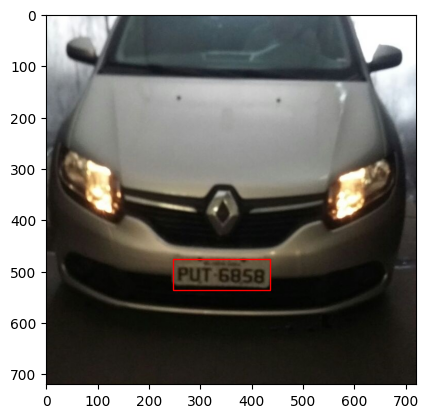

In [7]:
# Exemplo de uma imagem anotada do dataset
img = ds.image_at(120)
show_image_with_plate(img)

### Variedade nos formatos de Placas

Visto que foram coletadas imagens de diversos países, temos uma diferença considerável no formato das placas e letras que as compõem.

Placa do Brasil (BR)
Placa: JSG9648


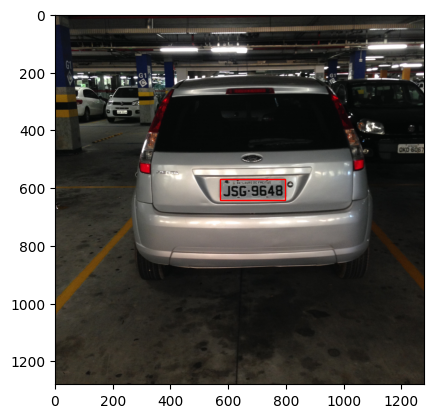

In [8]:
print('Placa do Brasil (BR)')
img = ds.image('JSG9648.jpg')
show_image_with_plate(img)

Placa dos Estados Unidos (US)
Placa: 980YTB


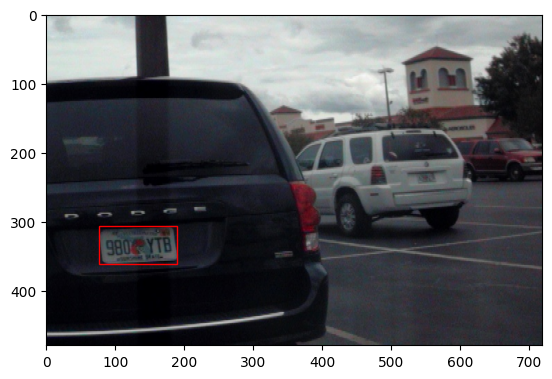

In [9]:
print('Placa dos Estados Unidos (US)')
img = ds.image('car14.jpg')
show_image_with_plate(img)

Placa dos Estados Unidos (US)
Placa: 10DTM


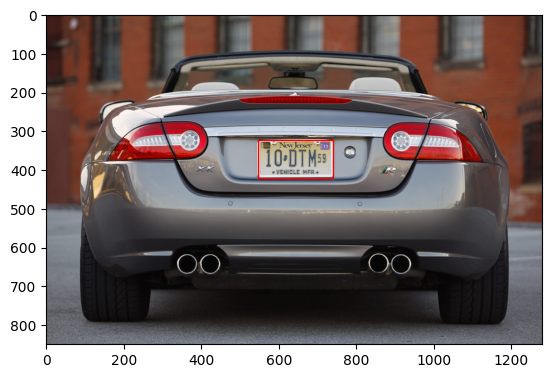

In [10]:
print('Placa dos Estados Unidos (US)')
img = ds.image('car7.jpg')
show_image_with_plate(img)

Placa da Europa (EU)
Placa: FWE50


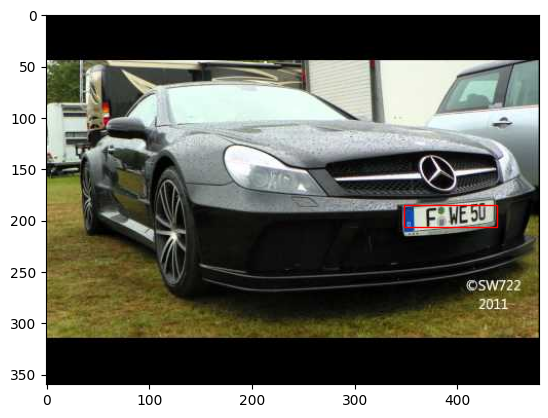

In [11]:
print('Placa da Europa (EU)')
img = ds.image('eu3.jpg')
show_image_with_plate(img)

Placa da Europa (EU)
Placa: VW4X4WP


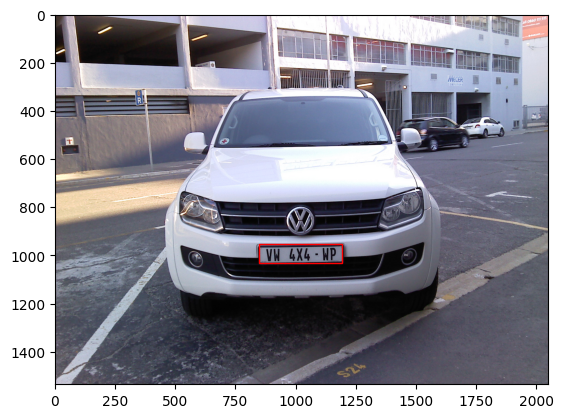

In [12]:
print('Placa da Europa (EU)')
img = ds.image('eu7.jpg')
show_image_with_plate(img)

# SimpleANPR: Uma abordagem simplificada para Reconhecimento de Placas Veiculares

Essa seção contém um comparativo de 3 abordagens para ANPR utilizando o framework proposto. Especificamente, testamos 3 formas de detecção de placas diferentes: (i) baseada em Bordas; (ii) baseada em Cor/Textura; (iii) baseada em Classificadores.


In [13]:
# ==== Imports ====
import json

import cv2
import numpy as np
import pandas as pd
import shapely
import textdistance
from torchmetrics.functional.text import char_error_rate

from anpr.binarization.adaptative_gaussian import AdaptativeGaussianBinarizer
from anpr.binarization.adaptative_mean import AdaptativeMeanBinarizer
from anpr.binarization.kittler import KittlerBinarizer
from anpr.binarization.otsu import OtsuBinarizer
from anpr.binarization.simple import SimpleBinarizer
from anpr.core.binarizer import Binarizer
from anpr.core.image_processor import ImageProcessor
from anpr.core.plate_detector import DetectionResult, PlateDetector
from anpr.datasets.open_alpr import OpenALPRDataset, OpenALPRImage
from anpr.detection.estimator_detector import EstimatorDetector
from anpr.detection.wavelet_detector import WaveletDetector
from anpr.generic.brightness import Brightness
from anpr.generic.contrast import Contrast
from anpr.generic.filter_bilateral import FilterBilateral
from anpr.generic.filter_gaussian import FilterGaussian
from anpr.generic.filter_mean import FilterMean
from anpr.generic.filter_median import FilterMedian
from anpr.generic.filter_nlm import FilterNLM
from anpr.generic.grayscale import GrayScale
from anpr.generic.histogram_normalization import HistogramNormalization
from anpr.generic.morphological_closing import MorphologicalClosing
from anpr.generic.morphological_opening import MorphologicalOpening
from anpr.generic.negative import Negative
from anpr.interpolation.bicubic import Bicubic
from anpr.interpolation.bilinear import Bilinear
from anpr.interpolation.lanczos import Lanczos
from anpr.ocr.easy_ocr import EasyOCR

In [14]:
# ==== Definição de classes utilitárias ====
class Identity(ImageProcessor):
    def process(self, image: np.ndarray) -> np.ndarray:
        return image


class AggregateProcessor(ImageProcessor):
    """Agregador de etapas de processamento
    sequencial. Aplica cada um dos processamentos
    de forma sequencial (i.e., saída de um é entrada
    para o próximo).
    """

    def __init__(self, processors: list[ImageProcessor]) -> None:
        self._processors = processors

    def process(self, image: np.ndarray) -> np.ndarray:
        for p in self._processors:
            image = p.process(image)

        return image


class DetectorWithProcessing(PlateDetector):
    def __init__(self,
                 detector: PlateDetector,
                 processor: ImageProcessor,
                 apply_processor_in_detect: bool = False):
        self._detector = detector
        self._processor = processor
        self._apply = apply_processor_in_detect

    @property
    def detector(self) -> PlateDetector:
        return self._detector

    @property
    def processor(self) -> ImageProcessor:
        return self._processor

    def detect(self, image: np.ndarray) -> DetectionResult:
        if self._apply:
            image = self.processor.process(image)

        return self._detector.detect(image)

In [15]:
# ==== Definição de variáveis utilitárias ====
# Threshold para considerar o overlap de retângulos
#   como correto.
correct_overlap_th: float = 0.2

# Pré-processamento para o OCR, inicializamos como identidade.
preprocessing_ocr = Identity()

# EasyOCR, iniciamos com a linguagem padrão.
ocr = EasyOCR()

In [16]:
# ==== Definição de funções utilitárias ====
def calculate_metrics(detector: PlateDetector,
                      ds: OpenALPRDataset,
                      indices: list[int] | None = None) -> dict:
    if indices is None:
        indices = list(range(ds.total_images()))

    metrics = {
        'Imagens Segmentadas': 0,
        'Imagens não Segmentadas': 0,
        'Acertos Detecção': 0,
        'Erros Detecção': 0,
        'CER': [[],
                []],
    }

    # Adicionando entradas por país
    for country in ['br', 'eu', 'us']:
        metrics.update({
            country: {
                'Imagens Segmentadas': 0,
                'Imagens não Segmentadas': 0,
                'Acertos Detecção': 0,
                'Erros Detecção': 0,
                'CER': [[],
                        []]
            }
        })

    def _get_country(name: str):
        if name in ds.br_plates():
            return 'br'

        if name in ds.us_plates():
            return 'us'

        if name in ds.eu_plates():
            return 'eu'

        raise ValueError('País não encontrado')

    def _correct_plate(true, pred):
        true_rect = shapely.box(xmin=true[0], xmax=true[0] + true[2],
                                ymin=true[1], ymax=true[1] + true[3])
        pred_rect = shapely.box(xmin=pred[0], xmax=pred[0] + pred[2],
                                ymin=pred[1], ymax=pred[1] + pred[3])

        if not pred_rect.intersects(true_rect):
            return False

        intersection_area = shapely.intersection(true_rect, pred_rect).area
        union_area = shapely.union(true_rect, pred_rect).area
        iou = intersection_area / union_area
        return iou > correct_overlap_th

    def _recognized_text(pred_plate_img: np.ndarray) -> str:
        # Obtendo predito
        plate_img = pred_plate_img.copy()
        plate_img = preprocessing_ocr.process(plate_img)
        pred_text = ocr.extract_text(plate_img)

        return pred_text

    for i in indices:
        ds_img = ds.image_at(i)
        detection = detector.detect(ds_img.image)
        image_country = _get_country(ds_img.name)

        if detection.found_plate:
            # Atualizando quantidade de imagens segmentadas
            metrics['Imagens Segmentadas'] += 1
            metrics[image_country]['Imagens Segmentadas'] += 1

            # Checando se encontrou a placa correta
            if _correct_plate(ds_img.plate_rect,
                              detection.plate_polygon):
                # Atualizando número de acertos
                metrics['Acertos Detecção'] += 1
                metrics[image_country]['Acertos Detecção'] += 1

                # Obtendo placa ground-truth
                true_text = ds_img.plate_text

                # Obtendo região da placa na imagem original
                x, y, w, h = detection.plate_polygon
                pred_plate = ds_img.image[y:y+h, x:x+w]

                # Obtendo saídas do OCR
                pred_text = _recognized_text(pred_plate)

                # Salvando resultados
                metrics['CER'][0].append(true_text)
                metrics[image_country]['CER'][0].append(true_text)
                metrics['CER'][1].append(pred_text)
                metrics[image_country]['CER'][1].append(pred_text)
            else:
                metrics['Erros Detecção'] += 1
                metrics[image_country]['Erros Detecção'] += 1
        else:
            metrics['Imagens não Segmentadas'] += 1
            metrics[image_country]['Imagens não Segmentadas'] += 1

    # Calculando CER
    metrics['CER'] = char_error_rate(
        preds=metrics['CER'][1],
        target=metrics['CER'][0]).item()

    for country in ['br', 'eu', 'us']:
        metrics[country]['CER'] = char_error_rate(
            preds=metrics[country]['CER'][1],
            target=metrics[country]['CER'][0]).item()

    # Retornando métricas
    return metrics


def show_detection(detector: DetectorWithProcessing,
                   ds: OpenALPRDataset,
                   image_idx: int,
                   color_true: str = 'g',
                   color_candidate: str = 'b',
                   color_selected: str = 'r',
                   cmap_processed=None):
    global ocr
    global preprocessing_ocr

    ds_img = ds.image_at(image_idx)
    detection = detector.detect(ds_img.image)
    processed_img = detector.processor.process(ds_img.image)

    fig, axs = plt.subplots(1, 2,
                            figsize=(12, 12),
                            facecolor='w',
                            edgecolor='k')
    axs = axs.ravel()

    def _add_patch(ax, x, y, w, h, color):
        axs[i].add_patch(patches.Rectangle((x, y), w, h,
                                           linewidth=1,
                                           edgecolor=color,
                                           facecolor='none'))

    for i, img in enumerate([ds_img.image,
                             processed_img]):
        cmap = None
        if i > 0:
            cmap = cmap_processed

        # Colocando a imagem
        axs[i].imshow(img, cmap=cmap)

        # Adicionando marcação real da placa
        _add_patch(axs[i],
                   *ds_img.plate_rect,
                   color_true)
        if i == 0:
            print(f'Placa: {ds_img.plate_text}')

        # Adicionando marcações da plata
        if detection.found_plate:
            _add_patch(axs[i],
                       *detection.plate_polygon,
                       color_selected)
            if i == 0:
                try:
                    p_img = preprocessing_ocr.process(detection.plate_image)
                    print(f'Placa extraída: {ocr.extract_text(p_img)}')
                except Exception:
                    print('Nenhuma placa encontrada.')

        # Adicionando candidatos (se disponíveis)
        extras = detection.extras
        if extras is not None:
            if hasattr(extras, 'candidates'):
                for c in getattr(extras, 'candidates'):
                    if c == detection.plate_polygon:
                        continue

                    _add_patch(axs[i],
                               *c,
                               color_candidate)


def accuracy_from_metrics(metrics: dict) -> float:
    total = metrics['Imagens Segmentadas'] + metrics['Imagens não Segmentadas']
    return metrics['Acertos Detecção'] / total

## Ground-Truth: Melhores resultados com o EasyOCR

Antes de comparar os resultados com os detectores de placa, vamos calcular quais melhores possíveis resultados que podemos esperar considerando as anotações presentes no dataset (ground-truth) com o EasyOCR. 


In [17]:
import optuna
from optuna.samplers import TPESampler

# === Buscando a melhor configuração de pré-processamento + modelo ===
# Visto que o principal desenvolvimento no projeto voltou-se a detecção
#   da placa, vamos utilizar a melhor configuração do EasyOCR no conjunto
#   de dados completo.

if RUN_OPTIMIZATION_EASY_OCR:
    _LOW_PASS = {
        'gaussian': FilterGaussian,
        'mean': FilterMean,
        'median': FilterMedian
    }

    _INTERP = {
        'bicubic': Bicubic,
        'bilinear': Bilinear,
        'lanczos': Lanczos,
    }

    def objective(trial):
        # Obtendo configurações de pré-processamento
        language = trial.suggest_categorical("language", ['pt', 'en',
                                                          'es', 'it',
                                                          'fr'])

        steps = {
            'first_interp': trial.suggest_categorical("first_interp", ['identity', 'bicubic',
                                                                       'bilinear', 'lanczos']),
            'low_pass': trial.suggest_categorical("low_pass", ['identity', 'gaussian',
                                                               'mean', 'median']),
            'morphological': trial.suggest_categorical("morphological", ['identity', 'opening', 'closing']),
            'luminosity': trial.suggest_categorical("luminosity", ['identity', 'histogram_normalization',
                                                                   'contrast', 'brightness']),
            'binarizer': trial.suggest_categorical("binarizer", ['identity',
                                                                 'otsu',
                                                                 'kittler']),
            'local_binarizer': trial.suggest_categorical("local_binarizer", ['identity',
                                                                             'adaptative_mean',
                                                                             'adaptative_mean']),
        }

        params = {
            'low_pass_kernel': trial.suggest_categorical("low_pass_kernel", [3, 5, 7, 11, 17]),
            'morph_shape': trial.suggest_categorical("morph_shape", [cv2.MORPH_CROSS, cv2.MORPH_ELLIPSE,
                                                                     cv2.MORPH_RECT]),
            'morph_size': trial.suggest_categorical("morph_size", [3, 5, 7, 11]),
            'brightness_offset': trial.suggest_int("brightness_offset", -50, 50, step=10),
            'contrast_multiplier': trial.suggest_float("contrast_multiplier", 0.25, 2.0, step=0.25),
            'interp_factor': trial.suggest_float("interp_factor", 0.25, 4.0, step=0.25),
            'adaptative_size': trial.suggest_categorical("adaptative_size", [3, 5, 11, 17]),
            'adaptative_C': trial.suggest_int("adaptative_C", 5, 17, step=2),
        }

        # Criando o conjunto de pré-processamento
        processing = [GrayScale()]

        for s, v in steps.items():
            processor = None

            if v == 'identity':
                continue

            if s == 'low_pass':
                kernel_size = params['low_pass_kernel']
                processor = _LOW_PASS[v](kernel_size)
            elif s == 'morphological':
                shape = params['morph_shape']
                size = params['morph_size']
                element = cv2.getStructuringElement(shape, (size, size))
                processor = MorphologicalClosing if v == 'closing' else MorphologicalOpening
                processor = processor(element)
            elif s == 'luminosity':
                if 'histogram' in v:
                    processor = HistogramNormalization()
                elif v == 'contrast':
                    processor = Contrast(params['contrast_multiplier'])
                elif v == 'brightness':
                    processor = Brightness(params['brightness_offset'])
            elif s == 'binarizer':
                processor = OtsuBinarizer() if v == 'otsu' else KittlerBinarizer()
            elif s == 'local_binarizer':
                size = params['adaptative_size']
                C = params['adaptative_C']
                processor = AdaptativeMeanBinarizer if 'mean' in v else AdaptativeGaussianBinarizer
                processor = processor(size, C)
            elif 'interp' in s:
                factor = params['interp_factor']
                processor = _INTERP[v](None, factor)

            processing.append(processor)

        # Convertendo a lista de processamento para um ImageProcessor
        processing = AggregateProcessor(processing)
        ocr = EasyOCR(language)

        # Calculando CER
        true_texts = []
        pred_texts = []

        for i in range(ds.total_images()):
            ds_img = ds.image_at(i)
            x, y, w, h = ds_img.plate_rect
            plate_img = ds_img.image[y:y+h, x:x+w].copy()
            plate_img = processing.process(plate_img)

            # Obtendo saída do OCR
            plate_text = ds_img.plate_text
            pred_text = ocr.extract_text(plate_img)

            true_texts.append(plate_text)
            pred_texts.append(pred_text)

        cer = char_error_rate(preds=pred_texts,
                              target=true_texts).item()

        # Armazenando o pré-processador
        trial.set_user_attr('processor', processing)
        trial.set_user_attr('language', language)

        # Usando CER como objetivo
        return cer

    # Iniciando experimento
    sampler = TPESampler(seed=rng.integers(0, 9999))
    study = optuna.create_study(study_name='easy_ocr_config',
                                direction="minimize",
                                sampler=sampler)
    study.optimize(objective,
                   n_trials=100,
                   n_jobs=1,
                   show_progress_bar=True)

    # Atualizando com as melhores configurações para o OCR
    preprocessing_ocr = study.best_trial.user_attrs['processor']
    ocr = EasyOCR(study.best_trial.user_attrs['language'])

    del sampler
    del study
    del _LOW_PASS
    del _INTERP
    del objective
else:
    print('Pulando otimização das configurações para o EasyOCR. '
          'Utilizando valores hard-coded da última otimização.')
    print('Melhor resultado alcançou 0.372022807598114 de CER (Character Error Rate).')
    preprocessing_ocr = AggregateProcessor([GrayScale(),
                                            Bicubic(None, 2.75),
                                            FilterGaussian(3),
                                            Brightness(20),
                                            OtsuBinarizer()])
    ocr = EasyOCR('en')

Pulando otimização das configurações para o EasyOCR. Utilizando valores hard-coded da última otimização.
Melhor resultado alcançou 0.372022807598114 de CER (Character Error Rate).


/home/moesiof/Work/UFRPE/anpr/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
def ground_truth_cer(ds: OpenALPRDataset,
                     indices: list[int] | None = None):
    if indices is None:
        indices = list(range(ds.total_images()))

    true_texts = []
    pred_texts = []

    for i in indices:
        ds_img = ds.image_at(i)
        x, y, w, h = ds_img.plate_rect
        plate_img = ds_img.image[y:y+h, x:x+w].copy()
        plate_img = preprocessing_ocr.process(plate_img)

        # Obtendo saída do OCR
        plate_text = ds_img.plate_text
        pred_text = ocr.extract_text(plate_img)

        true_texts.append(plate_text)
        pred_texts.append(pred_text)

    return {
        'CER': char_error_rate(
            preds=pred_texts,
            target=true_texts).item()
    }


print(json.dumps(ground_truth_cer(ds),
                 indent=2,
                 ensure_ascii=False))

{
  "CER": 0.372022807598114
}


## Abordagem 1: Detecção baseada em Bordas

### Exemplo "Bom"

### Exemplo "Médio"

### Exemplo "Ruim"

## Abordagem 2: Detecção baseada em Textura (Wavelet)

In [19]:
baseline_wavelet_detector = DetectorWithProcessing(WaveletDetector(),
                                                   Identity(),
                                                   apply_processor_in_detect=False)
metrics_baseline_wavelet_detector = calculate_metrics(baseline_wavelet_detector,
                                                      ds)
print(json.dumps(metrics_baseline_wavelet_detector,
                 indent=2,
                 ensure_ascii=False))

{
  "Imagens Segmentadas": 355,
  "Imagens não Segmentadas": 89,
  "Acertos Detecção": 129,
  "Erros Detecção": 226,
  "CER": 0.507230281829834,
  "br": {
    "Imagens Segmentadas": 99,
    "Imagens não Segmentadas": 15,
    "Acertos Detecção": 62,
    "Erros Detecção": 37,
    "CER": 0.382488489151001
  },
  "eu": {
    "Imagens Segmentadas": 67,
    "Imagens não Segmentadas": 41,
    "Acertos Detecção": 51,
    "Erros Detecção": 16,
    "CER": 0.5854341983795166
  },
  "us": {
    "Imagens Segmentadas": 189,
    "Imagens não Segmentadas": 33,
    "Acertos Detecção": 16,
    "Erros Detecção": 173,
    "CER": 0.75
  }
}


### Exemplo "Bom"

Placa: RK819AM
Placa extraída: YRKE89A


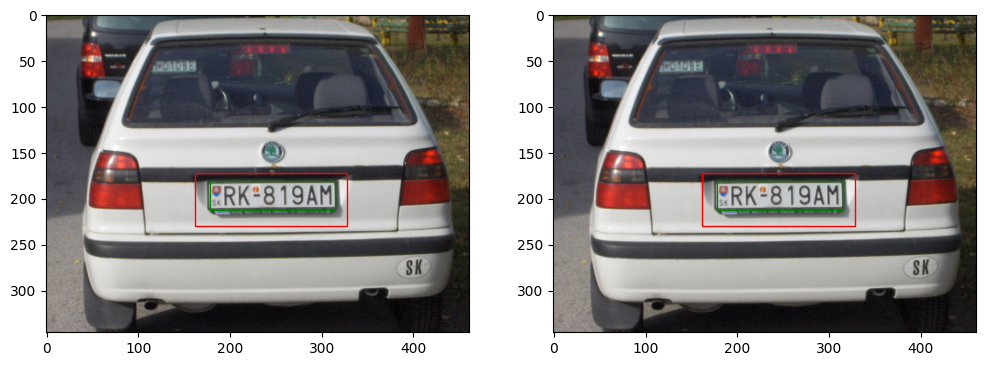

In [20]:
show_detection(baseline_wavelet_detector, ds, 200, cmap_processed='gray')

### Exemplo "Médio"

Placa: JRV1942
Placa extraída: JRVT3


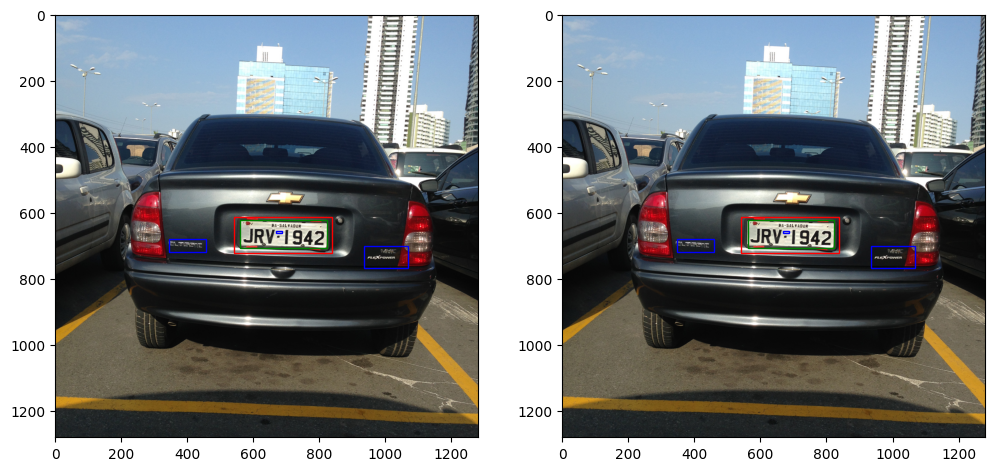

In [21]:
show_detection(baseline_wavelet_detector, ds, 26, cmap_processed='gray')

### Exemplo "Ruim"

Placa: DH5X9P


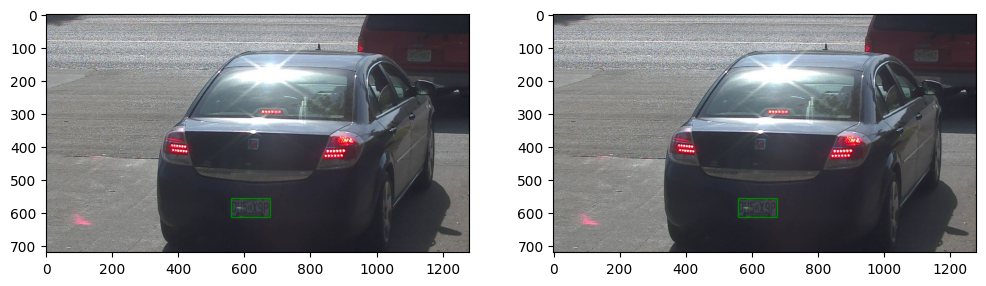

In [22]:
show_detection(baseline_wavelet_detector, ds, 280, cmap_processed='gray')

## Abordagem 3: Detecção baseada em Classificadores

In [23]:
# Processamento baseline
baseline_estimator_processing = AggregateProcessor([FilterNLM(21),
                                                    FilterBilateral(11, 5, 5),
                                                    GrayScale(),
                                                    Brightness(-30),
                                                    HistogramNormalization(),
                                                    Contrast(0.5),
                                                    OtsuBinarizer(),
                                                    AdaptativeMeanBinarizer(11, 5),
                                                    Negative()])

# Detector baseline
baseline_estimator_detector = EstimatorDetector(seed=rng_estimator.integers(0, 9999),
                                                estimator_algorithm='gaussian_process',
                                                features=['color', 
                                                          'texture', 
                                                          'shape'],
                                                scaler='Standard',
                                                preprocessing=baseline_estimator_processing,
                                                pp_in_predict=True,
                                                max_ch_prop=0.75,
                                                max_rect_ratio=0.4,
                                                min_rect_ratio=0.005,
                                                rect_overlap_th=0.6,
                                                max_neighbor_th=0.05,
                                                ch_dilate_size=25,
                                                ch_dilate_iterations=3,
                                                plate_rect_min_ratio=0.7)

# Treinamento com alguns exemplos de placas
n_samples = 40
rand_indices = rng_estimator.choice(list(range(ds.total_images())),
                                    replace=False,
                                    size=n_samples).tolist()
baseline_estimator_detector.fit(rand_indices, ds)

# Calculando métricas
baseline_estimator_detector = DetectorWithProcessing(baseline_estimator_detector,
                                                     baseline_estimator_processing,
                                                     apply_processor_in_detect=False)

metrics_baseline_estimator_detector = calculate_metrics(
    baseline_estimator_detector, ds)
print(json.dumps(metrics_baseline_estimator_detector,
                 indent=2,
                 ensure_ascii=False))

{
  "Imagens Segmentadas": 371,
  "Imagens não Segmentadas": 73,
  "Acertos Detecção": 204,
  "Erros Detecção": 167,
  "CER": 0.7526959180831909,
  "br": {
    "Imagens Segmentadas": 103,
    "Imagens não Segmentadas": 11,
    "Acertos Detecção": 84,
    "Erros Detecção": 19,
    "CER": 0.5442177057266235
  },
  "eu": {
    "Imagens Segmentadas": 75,
    "Imagens não Segmentadas": 33,
    "Acertos Detecção": 28,
    "Erros Detecção": 47,
    "CER": 0.8979591727256775
  },
  "us": {
    "Imagens Segmentadas": 193,
    "Imagens não Segmentadas": 29,
    "Acertos Detecção": 92,
    "Erros Detecção": 101,
    "CER": 0.907742977142334
  }
}


### Exemplo "Bom"

Placa: PJF4224
Placa extraída: IJF34224


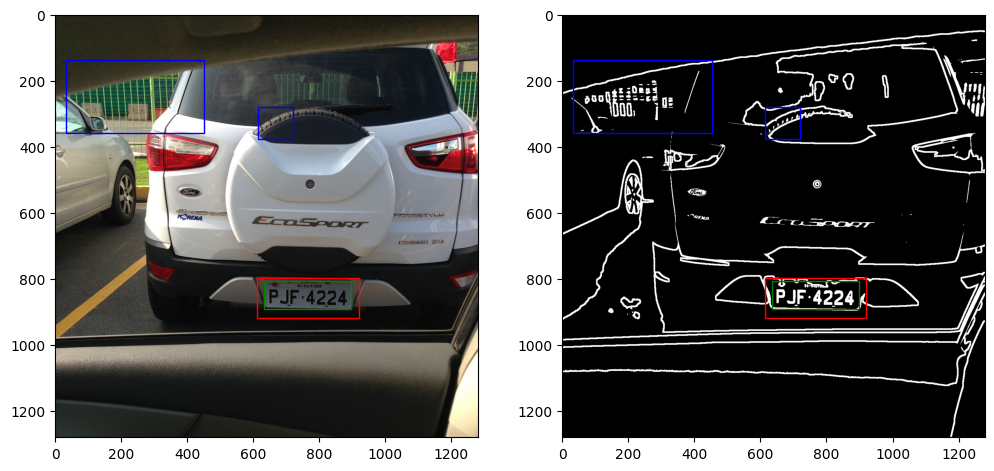

In [24]:
show_detection(baseline_estimator_detector, ds, 100, cmap_processed='gray')

### Exemplo "Médio"

Placa: 5UVR090
Placa extraída: WROO


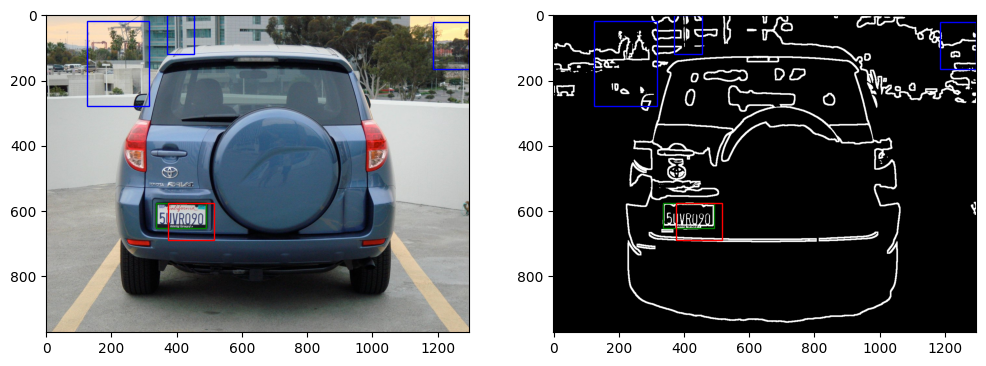

In [25]:
show_detection(baseline_estimator_detector, ds, 130, cmap_processed='gray')

### Exemplo "Ruim"

Placa: DK8F5L
Placa extraída: 7


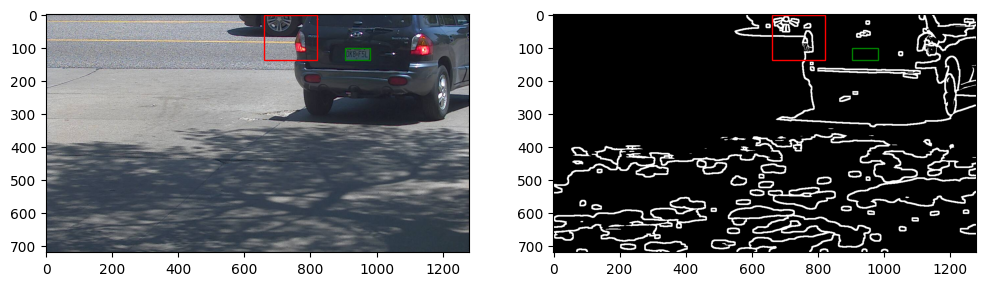

In [26]:
show_detection(baseline_estimator_detector, ds, 430, cmap_processed='gray')

## Otimização de Parâmetros: realizando a tunagem dos detectores

Para validar se existem combinações que produzem melhores resultados do que os baselines apresentados, vamos utilizar algoritmos de otimização de hiperparâmetros com o intuito de gerar automaticamente combinações de pré-processamento, parâmetros e afins.

In [27]:
# ==== Abordagem 1 ====
if RUN_OPTIMIZATION_EDGE:
    # Adicionar código usando optuna aqui
    pass
else:
    pass

In [28]:
# ==== Abordagem 2 ====
tuned_wavelet_detector = None
metrics_tuned_wavelet_detector = None

if RUN_OPTIMIZATION_WAVELET:
    _LOW_PASS = {
        'gaussian': FilterGaussian,
        'mean': FilterMean,
        'median': FilterMedian
    }

    _INTERP = {
        'bicubic': Bicubic,
        'bilinear': Bilinear,
        'lanczos': Lanczos,
    }

    def objective(trial):
        # Obtendo etapas de pré-processamento
        preprocessing_steps = {
            'low_pass': trial.suggest_categorical("low_pass", ['identity', 'gaussian',
                                                               'mean', 'median']),
            'morphological': trial.suggest_categorical("morphological", ['identity', 'opening', 'closing']),
            'luminosity': trial.suggest_categorical("luminosity", ['identity',  'histogram_normalization',
                                                                   'contrast', 'brightness']),

        }

        # Obtendo parâmetros do pré-processamento
        preprocessing_params = {
            'low_pass_kernel': trial.suggest_categorical("low_pass_kernel", [3, 5, 7, 11, 17,
                                                                             21, 25, 31]),
            'morph_shape': trial.suggest_categorical("morph_shape", [cv2.MORPH_CROSS, cv2.MORPH_ELLIPSE,
                                                                     cv2.MORPH_RECT]),
            'morph_size': trial.suggest_categorical("morph_size", [3, 5, 7, 11]),
            'brightness_offset': trial.suggest_int("brightness_offset", -50, 50, step=10),
            'contrast_multiplier': trial.suggest_float("contrast_multiplier", 0.25, 2.0, step=0.25)
        }

        # Criando o conjunto de pré-processamento
        processing = [GrayScale()]
        for s, v in preprocessing_steps.items():
            processor = None
            if v == 'identity':
                continue

            if s == 'low_pass':
                kernel_size = preprocessing_params['low_pass_kernel']
                processor = _LOW_PASS[v](kernel_size)
            elif s == 'morphological':
                shape = preprocessing_params['morph_shape']
                size = preprocessing_params['morph_size']
                element = cv2.getStructuringElement(shape, (size, size))
                processor = MorphologicalClosing if v == 'closing' else MorphologicalOpening
                processor = processor(element)
            elif s == 'luminosity':
                if 'histogram' in v:
                    processor = HistogramNormalization()
                elif v == 'contrast':
                    alpha = preprocessing_params['contrast_multiplier']
                    processor = Contrast(alpha)
                elif v == 'brightness':
                    beta = preprocessing_params['brightness_offset']
                    processor = Brightness(beta)

            assert processor is not None
            processing.append(processor)

        processing = AggregateProcessor(processing)

        # Obtendo parâmetros do detector
        params = {
            'binarizer': trial.suggest_categorical('binarizer', ['simple', 'otsu',
                                                                 'kittler']),
            'dilation_kernel': trial.suggest_int("dilation_kernel", 3, 21),
            'dilation_iterations': trial.suggest_int("dilation_iterations", 1, 4)
        }

        if params['binarizer'] == 'simple':
            params['binarizer'] = SimpleBinarizer(45)
        elif params['binarizer'] == 'otsu':
            params['binarizer'] = OtsuBinarizer()
        else:
            params['binarizer'] = KittlerBinarizer()

        params['dilation_kernel'] = (params['dilation_kernel'],
                                     params['dilation_kernel'])

        # Criando detector
        wavelet_detector = WaveletDetector(**params)
        detector = DetectorWithProcessing(wavelet_detector, processing,
                                          apply_processor_in_detect=True)

        # Calculando métricas
        metrics = calculate_metrics(detector, ds)

        # Adicionando a seed como informação do trial
        trial.set_user_attr('detector', detector)
        trial.set_user_attr('metrics', metrics)

        # Usando acurácia como objetivo
        return accuracy_from_metrics(metrics)

    # Iniciando experimento
    sampler = TPESampler(seed=rng_wavelet.integers(0, 9999))
    study = optuna.create_study(study_name='wavelet_detector',
                                direction="maximize",
                                sampler=sampler)
    study.optimize(objective,
                   n_trials=200,
                   n_jobs=1,
                   show_progress_bar=True)

    # Obtendo os melhores resultados
    tuned_wavelet_detector = study.best_trial.user_attrs['detector']
    metrics_tuned_wavelet_detector = calculate_metrics(
        tuned_wavelet_detector, ds)

    # Removendo variáveis que não serão mais usadas
    del sampler
    del study
    del _INTERP
    del _LOW_PASS
    del objective
else:
    print('Otimização não realizada, aproveitando resultados hard-coded.')
    tuned_wavelet_detector = DetectorWithProcessing(WaveletDetector(
        binarizer=KittlerBinarizer(),
        dilation_kernel=(6, 6),
        dilation_iterations=3),
        AggregateProcessor([GrayScale(),
                            Contrast(2.0)]),
        apply_processor_in_detect=True)
    metrics_tuned_wavelet_detector = calculate_metrics(tuned_wavelet_detector,
                                                       ds)
print(json.dumps(metrics_tuned_wavelet_detector,
                    indent=2,
                    ensure_ascii=False))

Otimização não realizada, aproveitando resultados hard-coded.
{
  "Imagens Segmentadas": 351,
  "Imagens não Segmentadas": 93,
  "Acertos Detecção": 21,
  "Erros Detecção": 330,
  "CER": 0.5782312750816345,
  "br": {
    "Imagens Segmentadas": 102,
    "Imagens não Segmentadas": 12,
    "Acertos Detecção": 17,
    "Erros Detecção": 85,
    "CER": 0.529411792755127
  },
  "eu": {
    "Imagens Segmentadas": 45,
    "Imagens não Segmentadas": 63,
    "Acertos Detecção": 3,
    "Erros Detecção": 42,
    "CER": 0.7142857313156128
  },
  "us": {
    "Imagens Segmentadas": 204,
    "Imagens não Segmentadas": 18,
    "Acertos Detecção": 1,
    "Erros Detecção": 203,
    "CER": 1.0
  }
}


In [29]:
# ==== Abordagem 3 ====
# Para essa abordagem, temos muitas possibilidade de
#   parâmetros para otimização.
tuned_estimator_detector = None
metrics_tuned_estimator_detector = None

if RUN_OPTIMIZATION_ESTIMATOR:
    def objective(trial):
        # Obtendo parâmetros do pré-processamento
        preprocessing_params = {
            'nlm_h': trial.suggest_int("nlm_h", 10, 40, step=5),
            'bilateral_k': trial.suggest_int("bilateral_k", 10, 22, step=2),
            'bilateral_sigma': trial.suggest_int("bilateral_sigma", 5, 85, step=10),
            'brightness_offset': trial.suggest_int("brightness_offset", -50, 50, step=10),
            'contrast_multiplier': trial.suggest_float("contrast_multiplier", 0.25, 2.0, step=0.25),
            'first_binarizer': trial.suggest_categorical('first_binarizer', ['otsu', 'kittler']),
            'adaptative_size': trial.suggest_categorical("adaptative_size", [3, 5, 11, 17, 23, 25, 31]),
            'adaptative_C': trial.suggest_int("adaptative_C", 5, 17, step=2),
        }

        # Criando o conjunto de pré-processamento
        processing = AggregateProcessor([
            FilterNLM(preprocessing_params['nlm_h']),
            FilterBilateral(preprocessing_params['bilateral_k'],
                            preprocessing_params['bilateral_sigma'],
                            preprocessing_params['bilateral_sigma']),
            GrayScale(),
            Brightness(preprocessing_params['brightness_offset']),
            HistogramNormalization(),
            Contrast(preprocessing_params['contrast_multiplier']),
            OtsuBinarizer() if preprocessing_params['first_binarizer'] == 'otsu' else KittlerBinarizer(),
            AdaptativeMeanBinarizer(preprocessing_params['adaptative_size'],
                                    preprocessing_params['adaptative_C']),
            Negative()])

        # Obtendo parâmetros do detector
        params = {
            'estimator_algorithm': trial.suggest_categorical('estimator_algorithm', ['logistic_regression',
                                                                                     'gaussian_process',
                                                                                     'decision_tree',
                                                                                     'extra_trees',
                                                                                     'random_forest']),
            'scaler': trial.suggest_categorical('scaler', ['MinMax', 'Standard']),
            'features': trial.suggest_categorical('features', ['color+shape+texture',
                                                               'color+shape',
                                                               'color+texture',
                                                               'shape+texture']).split('+'),
            'max_ch_prop': trial.suggest_float("max_ch_prop", 0.5, 1.2, step=0.1),
            'max_rect_ratio': trial.suggest_float("max_rect_ratio", 0.3, 0.8, step=0.1),
            'min_rect_ratio': trial.suggest_float("min_rect_ratio", 0.002, 0.01, step=0.001),
            'rect_overlap_th': trial.suggest_float("rect_overlap_th", 0.5, 0.8, step=0.1),
            'max_neighbor_th': trial.suggest_float("max_neighbor_th", 0.02, 0.1, step=0.01),
            'ch_dilate_size': trial.suggest_int("ch_dilate_size", 11, 35),
            'ch_dilate_iterations': trial.suggest_int("ch_dilate_iterations", 1, 4),
            'plate_rect_min_ratio': trial.suggest_float("plate_rect_min_ratio", 0.5, 0.9, step=0.05)
        }

        # Criando detector
        detector_seed = rng_estimator.integers(0, 9999)
        detector = EstimatorDetector(seed=detector_seed,
                                     preprocessing=processing,
                                     **params)

        # Treinamento
        detector.fit(rand_indices, ds)

        # Calculando métricas
        detector = DetectorWithProcessing(detector,
                                          processing,
                                          apply_processor_in_detect=False)
        metrics = calculate_metrics(detector, ds)

        # Adicionando a seed como informação do trial
        trial.set_user_attr('seed', detector_seed)
        trial.set_user_attr('detector', detector)
        trial.set_user_attr('metrics', metrics)

        # Usando acurácia como objetivo
        return accuracy_from_metrics(metrics)

    # Iniciando experimento
    sampler = TPESampler(seed=rng_estimator.integers(0, 9999))
    study = optuna.create_study(study_name='estimator_detector',
                                direction="maximize",
                                sampler=sampler)
    study.optimize(objective,
                   n_trials=10,
                   n_jobs=1,
                   show_progress_bar=True)

    # Obtendo os melhores resultados
    tuned_estimator_detector = study.best_trial.user_attrs['detector']
    metrics_tuned_estimator_detector = study.best_trial.user_attrs['metrics']

    # Removendo variáveis que não serão mais usadas
    del sampler
    del study
    del objective
else:
    print('Otimização não realizada, aproveitando resultados hard-coded.')
    best_params = {
        'nlm_h': 15,
        'bilateral_k': 10,
        'bilateral_sigma': 35,
        'brightness_offset': -10,
        'contrast_multiplier': 1.5,
        'first_binarizer': 'otsu',
        'adaptative_size': 3,
        'adaptative_C': 9,
        'estimator_algorithm': 'decision_tree',
        'scaler': 'Standard',
        'features': 'color+shape'.split("+"),
        'max_ch_prop': 0.8,
        'max_rect_ratio': 0.7,
        'min_rect_ratio': 0.01,
        'rect_overlap_th': 0.5,
        'max_neighbor_th': 0.05,
        'ch_dilate_size': 15,
        'ch_dilate_iterations': 1,
        'plate_rect_min_ratio': 0.6
    }
    best_seed = 8357

    # Construindo o melhor pré-processamento
    tuned_estimator_processing = AggregateProcessor([
        FilterNLM(best_params.pop('nlm_h')),
        FilterBilateral(best_params.pop('bilateral_k'),
                        best_params['bilateral_sigma'],
                        best_params.pop('bilateral_sigma')),
        GrayScale(),
        Brightness(best_params.pop('brightness_offset')),
        HistogramNormalization(),
        Contrast(best_params.pop('contrast_multiplier')),
        OtsuBinarizer() if best_params.pop('first_binarizer') == 'otsu' else KittlerBinarizer(),
        AdaptativeMeanBinarizer(best_params.pop('adaptative_size'),
                                best_params.pop('adaptative_C')),
        Negative()])

    # Construindo o melhor detector
    tuned_estimator_detector = EstimatorDetector(seed=best_seed,
                                                 preprocessing=tuned_estimator_processing,
                                                 **best_params)
    tuned_estimator_detector.fit(rand_indices, ds)
    tuned_estimator_detector = DetectorWithProcessing(tuned_estimator_detector,
                                                      tuned_estimator_processing,
                                                      apply_processor_in_detect=False)

    # Calculando as métricas
    metrics_tuned_estimator_detector = calculate_metrics(
        tuned_estimator_detector, ds)

    # Removendo variáveis que não serão mais usadas
    del best_params
    del best_seed

print(json.dumps(metrics_tuned_estimator_detector, 
                 indent=2, 
                 ensure_ascii=False))

Otimização não realizada, aproveitando resultados hard-coded.
{
  "Imagens Segmentadas": 296,
  "Imagens não Segmentadas": 148,
  "Acertos Detecção": 109,
  "Erros Detecção": 187,
  "CER": 0.5595238208770752,
  "br": {
    "Imagens Segmentadas": 98,
    "Imagens não Segmentadas": 16,
    "Acertos Detecção": 56,
    "Erros Detecção": 42,
    "CER": 0.5127550959587097
  },
  "eu": {
    "Imagens Segmentadas": 73,
    "Imagens não Segmentadas": 35,
    "Acertos Detecção": 41,
    "Erros Detecção": 32,
    "CER": 0.5972222089767456
  },
  "us": {
    "Imagens Segmentadas": 125,
    "Imagens não Segmentadas": 97,
    "Acertos Detecção": 12,
    "Erros Detecção": 113,
    "CER": 0.6578947305679321
  }
}


## Tabela Comparativa dos Melhores Resultados

Considerando todos os experimentos, a tabela abaixo contém algumas métricas de avaliação.